<a href="https://colab.research.google.com/github/mayibongwemoyo/dawm/blob/main/multi_method_incremental_watermarking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture

import sys
!pip install torchaudio soundfile matplotlib scipy datasets pandas seaborn
!pip install audioseal

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/dawm/examples')
import noteb00k
from datasets import load_dataset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torchaudio
import numpy as np
from scipy import stats
from audioseal import AudioSeal


# Constants
NUM_AUDIOS_PER_METHOD = 5
NUM_WATERMARKS = 4
SAMPLE_RATE = 16000
sr =16000

# Initialize models
generator = AudioSeal.load_generator("audioseal_wm_16bits")
detector = AudioSeal.load_detector("audioseal_detector_16bits")

In [ ]:
# def embed_sfa(audio, sr, alpha=0.3):
#     """Sequential Fixed Alpha"""
#     if not isinstance(audio, torch.Tensor): ####ensuring tensor conversion
#         audio = torch.from_numpy(audio).float()

#     watermarked = audio.clone()
#     metrics = []
#     for i in range(NUM_WATERMARKS):
#         watermarked = generator(watermarked, sr, alpha=alpha)
#         metrics.append(calculate_metrics(audio, watermarked))
#     return watermarked, metrics

# def embed_sda(audio, sr):
#     """Sequential Decaying Alpha"""
#     if not isinstance(audio, torch.Tensor): ####ensuring tensor conversion
#         audio = torch.from_numpy(audio).float()

#     watermarked = audio.clone()
#     metrics = []
#     for i in range(NUM_WATERMARKS):
#         alpha = 0.5 / (i + 1)
#         watermarked = generator(watermarked, sr, alpha=alpha)
#         metrics.append(calculate_metrics(audio, watermarked))
#     return watermarked, metrics

# # CORRECTED EMBEDDING FUNCTION (PFB)
# def embed_pfb(audio, sr, alpha=0.5):
#     """Parallel Frequency Bands"""
#     fft = torch.fft.fft(audio)
#     bands = torch.chunk(fft, 4, dim=-1)

#     watermarked_bands = []
#     for band in bands:
#         wm_band = generator(band.real, sr, alpha=alpha) + 1j*band.imag  # Fix: 1j not lj
#         watermarked_bands.append(wm_band)

#     watermarked = torch.fft.ifft(torch.cat(watermarked_bands, dim=-1)).real
#     return watermarked, [calculate_metrics(audio, watermarked)]*4

In [ ]:
def embed_sfa(audio, sr, step, alpha=0.3):
    """Apply one watermark step (Sequential Fixed Alpha)"""
    watermarked = generator(audio, sample_rate=sr, alpha=alpha)
    return watermarked

def embed_sda(audio, sr, step, base_alpha=0.5):
    """Apply one watermark step (Sequential Decaying Alpha)"""
    alpha = base_alpha / (step + 1)  # +1 to avoid division by zero
    watermarked = generator(audio, sample_rate=sr, alpha=alpha)
    return watermarked

def embed_pfb(audio, sr, step, alpha=0.5):
    """Apply one watermark step (Parallel Frequency Bands)"""
    fft = torch.fft.fft(audio)
    bands = torch.chunk(fft, 4, dim=-1)
    band = bands[step % 4]  # Cycle through bands
    wm_band = generator(band.real, sample_rate=sr, alpha=alpha) + 1j * band.imag
    watermarked_bands = list(bands)
    watermarked_bands[step % 4] = wm_band
    return torch.fft.ifft(torch.cat(watermarked_bands, dim=-1)).real

In [ ]:
# def calculate_metrics(original, watermarked):
#     noise = watermarked - original
#     snr = 10 * torch.log10(original.pow(2).mean() / noise.pow(2).mean()).item()

#     # Test detection
#     msg = torch.randint(0, 2, (1, 16))
#     detector.message = msg
#     prob, detected = detector.detect_watermark(watermarked, sr)  # Added sr

#     return {
#         "snr": snr,  # Key renamed from "sm"
#         "ber": (msg != detected.round()).float().mean().item(),
#         "detection_prob": prob.item() if hasattr(prob, 'item') else prob
#     }

In [ ]:
def calculate_metrics(original, watermarked, method_name, step, num_fake=10):
    """Calculate metrics for a single watermark step"""
    noise = watermarked - original
    snr = 10 * torch.log10(original.pow(2).mean() / noise.pow(2).mean()).item()

    # Real message detection
    real_msg = torch.randint(0, 2, (1, 16))
    detector.message = real_msg
    prob_real, detected_real = detector.detect_watermark(watermarked, SAMPLE_RATE)
    ber_real = (real_msg != detected_real.round()).float().mean().item()

    # Fake message detection
    false_positives = 0
    for _ in range(num_fake):
        fake_msg = torch.randint(0, 2, (1, 16))
        detector.message = fake_msg
        prob_fake, _ = detector.detect_watermark(watermarked, SAMPLE_RATE)
        false_positives += int(prob_fake > 0.5)  # Threshold at 50% confidence

    return {
        "method": method_name,
        "step": step + 1,  # 1-based indexing
        "snr": snr,
        "ber": ber_real,
        "detection_prob": prob_real.item() if hasattr(prob_real, 'item') else prob_real,
        "false_positive_rate": false_positives / num_fake
    }

In [ ]:
def preprocess_audio(audio, sr):
    """Convert audio to standard format: (1, 1, T) @ 16kHz"""
    # Convert numpy arrays to tensor
    if isinstance(audio, np.ndarray):
        audio = torch.from_numpy(audio).float()

    # Ensure 3D shape: (batch=1, channels=1, time)
    if audio.dim() == 1:
        audio = audio.unsqueeze(0).unsqueeze(0)  # (1, 1, T)
    elif audio.dim() == 2:
        audio = audio.unsqueeze(0)  # (1, C, T)

    # Convert to mono if needed
    if audio.shape[1] > 1:
        audio = audio.mean(dim=1, keepdim=True)

    # Resample to 16kHz
    if sr != 16000:
        resampler = torchaudio.transforms.Resample(sr, 16000)
        audio = resampler(audio)

    return audio

### Batch Processing ###
NUM_AUDIOS_PER_METHOD = 5  # For hypothesis testing
SAMPLE_RATE = 16000


def process_batch(method_func, audios, method_name):
    results = []
    for audio, orig_sr in audios[:NUM_AUDIOS_PER_METHOD]:
        try:
            processed_audio = preprocess_audio(audio, orig_sr)
            watermarked = processed_audio.clone()

            # Apply watermarks incrementally
            for step in range(NUM_WATERMARKS):
                # Embed one watermark step
                watermarked = method_func(watermarked, SAMPLE_RATE, step)

                # Calculate metrics for this step
                metrics = calculate_metrics(
                    original=processed_audio,
                    watermarked=watermarked,
                    method_name=method_name,
                    step=step
                )
                results.append(metrics)

        except Exception as e:
            print(f"Failed {method_name} (Audio {len(results)+1}): {str(e)}")
    return pd.DataFrame(results)

###Load Dataset###
from huggingface_hub import notebook_login
# notebook_login()
dataset = load_dataset("facebook/voxpopuli", "en", split="validation",
                      streaming=True, trust_remote_code=True)
audios = [(example["audio"]["array"], example["audio"]["sampling_rate"])
          for example in dataset.take(15)]  # Limit to 15 samples

###Execute Processing###
methods = {
    "SFA": embed_sfa,
    "SDA": embed_sda,
    "PFB": embed_pfb
}

results = {
    name: process_batch(func, audios, name)  # Added method name
    for name, func in methods.items()
}

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# ANOVA test for SNR differences
f_val, p_val = stats.f_oneway(
    results["SFA"]["snr"],
    results["SDA"]["snr"],
    results["PFB"]["snr"]
)
print(f"SNR ANOVA: F={f_val:.2f}, p={p_val:.4f}")

# Pairwise t-tests for BER
from itertools import combinations
for (m1, m2) in combinations(methods.keys(), 2):
    t, p = stats.ttest_ind(results[m1]["ber"], results[m2]["ber"])
    print(f"{m1} vs {m2} BER: t={t:.2f}, p={p:.4f}")

SNR ANOVA: F=501.21, p=0.0000
SFA vs SDA BER: t=-1.15, p=0.2557
SFA vs PFB BER: t=-0.40, p=0.6929
SDA vs PFB BER: t=0.83, p=0.4102


In [ ]:
def print_metric_table(metric):
    """Print results grouped by audio and watermark"""
    print(f"\n{metric.upper()} RESULTS (Grouped by Audio)")

    for method in results:
        print(f"\nMethod: {method}")
        df = results[method].copy()

        # Add audio/watermark identifiers
        df['Audio'] = (df.index // NUM_WATERMARKS) + 1
        df['Watermark#'] = (df.index % NUM_WATERMARKS) + 1

        # Pivot table for clear grouping
        pivot_table = df.pivot_table(
            index='Audio',
            columns='Watermark#',
            values=metric,
            aggfunc='first'
        ).round(2)

        # Add cumulative delta column
        for audio in pivot_table.index:
            base = pivot_table.loc[audio, 1]
            pivot_table.loc[audio, 'Δ from 1st'] = pivot_table.loc[audio, 4] - base

        print(pivot_table)
        print("-"*50)

# Execute with all metrics
print_metric_table('snr')
print_metric_table('ber')
print_metric_table('detection_prob')
print_metric_table('false_positive_rate')


SNR RESULTS (Grouped by Audio)

Method: SFA
Watermark#      1      2      3      4  Δ from 1st
Audio                                             
1           34.04  29.53  26.83  25.19       -8.85
2           39.12  34.50  32.13  30.44       -8.68
3           35.64  30.78  28.28  26.60       -9.04
4           38.26  33.86  31.44  29.62       -8.64
5           37.61  32.76  30.24  28.66       -8.95
--------------------------------------------------

Method: SDA
Watermark#      1      2      3      4  Δ from 1st
Audio                                             
1           29.08  27.22  26.17  25.51       -3.57
2           34.66  32.57  31.45  30.86       -3.80
3           30.85  28.69  27.66  27.06       -3.79
4           33.40  31.52  30.49  29.96       -3.44
5           32.88  30.73  29.77  29.20       -3.68
--------------------------------------------------

Method: PFB
Watermark#      1      2      3      4  Δ from 1st
Audio                                             
1          

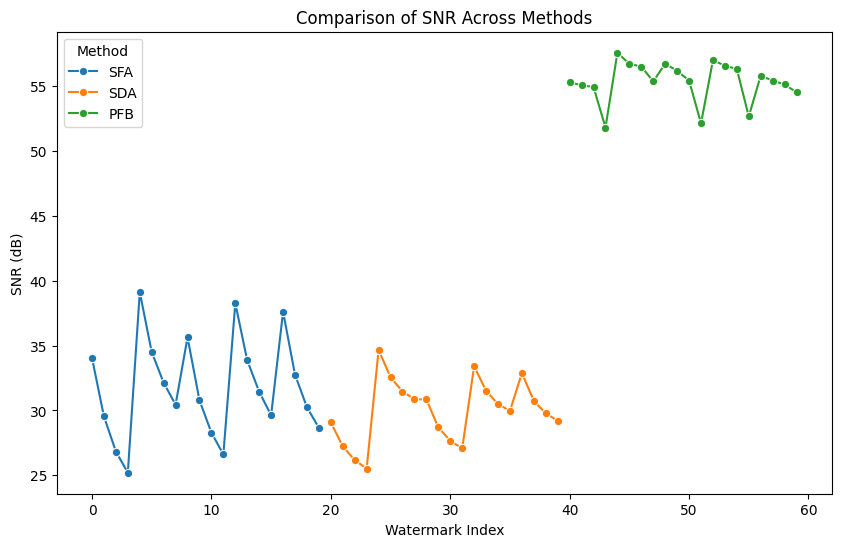

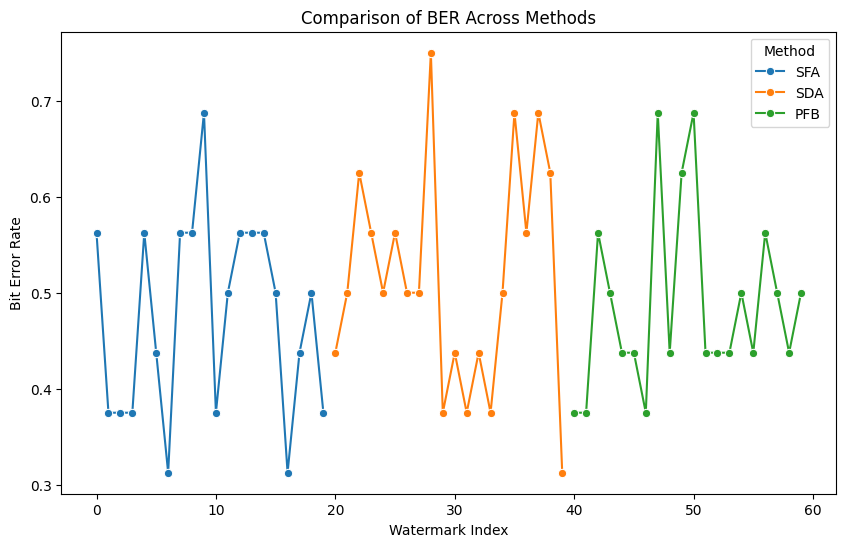

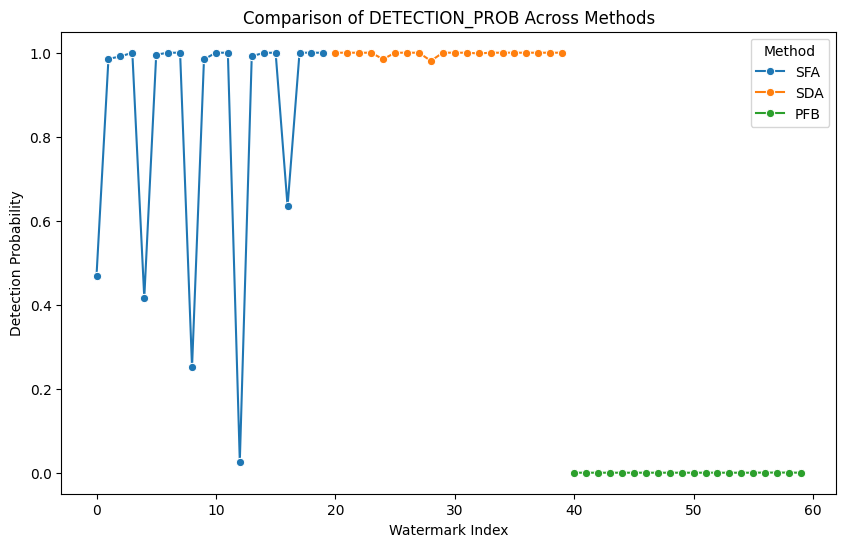

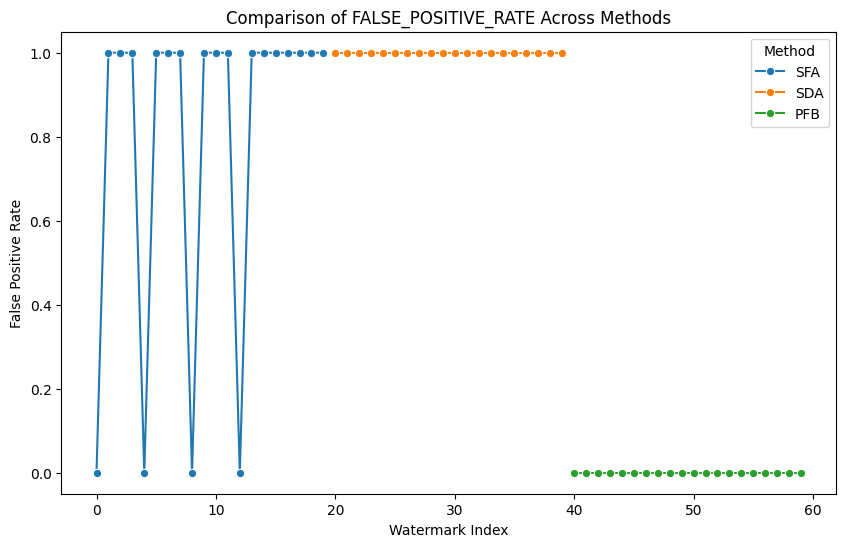

In [ ]:
def plot_metric(metric, ylabel):
    plt.figure(figsize=(10, 6))

    # Create a unified DataFrame with method labels
    plot_data = pd.concat({
        method: results[method][metric]
        for method in results.keys()
    }, axis=1).melt(var_name="Method", value_name=metric)

    sns.lineplot(
        data=plot_data,
        x=plot_data.index,  # Watermark index
        y=metric,
        hue="Method",  # Now properly defined
        marker="o",
        errorbar=("ci", 95)  # Use modern errorbar syntax
    )

    plt.title(f"Comparison of {metric.upper()} Across Methods")
    plt.xlabel("Watermark Index")
    plt.ylabel(ylabel)
    plt.show()

plot_metric("snr", "SNR (dB)")
plot_metric("ber", "Bit Error Rate")
plot_metric("detection_prob", "Detection Probability")
plot_metric("false_positive_rate", "False Positive Rate")